In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 

from scipy.stats import norm
from scipy.optimize import fsolve
from scipy.optimize import minimize
import scipy.integrate as integrate
from scipy import special
from scipy.special import erf, erfc
from scipy import optimize
from datetime import date
from datetime import datetime
import time 

In [2]:
# Preprocessing
amd_quotes = pd.read_csv('amd_quotedata.csv', parse_dates=['Expiration Date'], index_col=['Expiration Date'])
amd_calls = amd_quotes.iloc[:,0:11] # Remove puts
#amd_calls = amd_calls1.drop('2023-04-06', inplace=True) # Remove date before start date

S0 = 92.3
t0 = date(2023, 4, 8)
amd_calls['Strike/Spot'] = amd_calls['Strike']/S0
amd_calls['Mid'] = (amd_calls['Bid']+amd_calls['Ask'])/2
amd_calls
F_T = S0 #Assume 0 rate 0 divs


## First maturity

In [3]:
C1 = amd_calls.loc['2023-04-14']
C1 = C1.reset_index(drop=True)
C1

,Calls,Last Sale,Net,Bid,Ask,Volume,IV,Delta,Gamma,Open Interest,Strike,Strike/Spot,Mid
0,AMD230414C00083000,9.72,-0.105,9.55,9.80,166,0.4442,0.9452,0.0172,293,83.0,0.899242,9.675
1,AMD230414C00084000,9.05,0.150,8.65,8.85,22,0.4504,0.9287,0.0217,225,84.0,0.910076,8.750
2,AMD230414C00085000,8.10,0.075,7.70,7.90,134,0.4427,0.9068,0.0272,867,85.0,0.920910,7.800
3,AMD230414C00086000,7.00,-0.125,6.80,7.00,77,0.4352,0.8782,0.0337,569,86.0,0.931744,6.900
4,AMD230414C00087000,6.20,-0.125,5.95,6.15,101,0.4259,0.8417,0.0409,544,87.0,0.942579,6.050
5,AMD230414C00088000,5.50,-0.050,5.15,5.30,192,0.4269,0.7974,0.0483,457,88.0,0.953413,5.225
6,AMD230414C00089000,4.50,-0.300,4.40,4.50,165,0.4155,0.7456,0.0556,934,89.0,0.964247,4.450
7,AMD230414C00090000,3.76,-0.340,3.70,3.80,817,0.4147,0.6869,0.0622,1864,90.0,0.975081,3.750
8,AMD230414C00091000,3.07,-0.380,3.05,3.15,1194,0.4062,0.6223,0.0677,1272,91.0,0.985915,3.100
9,AMD230414C00092000,2.50,-0.365,2.48,2.50,8647,0.4024,0.5529,0.0714,1637,92.0,0.996750,2.490


In [4]:
def iv(p,K,T,r,S0):
    """
    Calculate implied volatility using Black-Scholes formula
    
    Parameters:
    p (float): Market price(s) of the option
    K (float): Strike price(s) of the option
    T (float): Time to expiry of the option, in years
    r (float): Risk-free interest rate, as a decimal
    S0 (float): Current price of the underlying asset
    """
    
    d1 = lambda sigma: (np.log(S0/K) + (r + 0.5*(sigma**2))*T) / (sigma*np.sqrt(T))
    d2 = lambda sigma: d1(sigma) - sigma*np.sqrt(T)
    option_price = lambda sigma: S0*norm.cdf(d1(sigma)) - K*np.exp(-r*T)*norm.cdf(d2(sigma))
    option_price_diff = lambda sigma: option_price(sigma) - p
    
    return fsolve(option_price_diff, 0.2*np.ones(len(p)))

def iv2(p,K,T,r,S0):
    """
    Calculate implied volatility using Black-Scholes formula
    
    Parameters:
    p (float): Market price(s) of the option
    K (float): Strike price(s) of the option
    T (float): Time to expiry of the option, in years
    r (float): Risk-free interest rate, as a decimal
    S0 (float): Current price of the underlying asset
    """
    
    d1 = lambda sigma: (np.log(S0/K) + (r + 0.5*(sigma**2))*T) / (sigma*np.sqrt(T))
    d2 = lambda sigma: d1(sigma) - sigma*np.sqrt(T)
    option_price = lambda sigma: S0*norm.cdf(d1(sigma)) - K*np.exp(-r*T)*norm.cdf(d2(sigma))
    option_price_diff = lambda sigma: option_price(sigma) - p
    
    #return fsolve(option_price_diff, 0.2*np.ones(len(p)))
    return optimize.root_scalar(option_price_diff, x0=0.2, bracket=(1E-6,5), method="brentq").root

def iv_2_vec(p, kk, T, r, S0):
    vals = []
    for pp,K in zip(p,kk):
        vals.append(iv2(pp,K,T,r,S0))

    return vals

In [5]:
# Which risk-free interest rate is used?
#iv_diff = lambda r: np.linalg.norm(iv(np.array(amd_calls_t1['Mid']),np.array(amd_calls_t1['Strike']),6/252,r,S0) - np.array(amd_calls_t1['IV']))
#r_ = minimize(iv_diff, 0.01)
#print(r_)

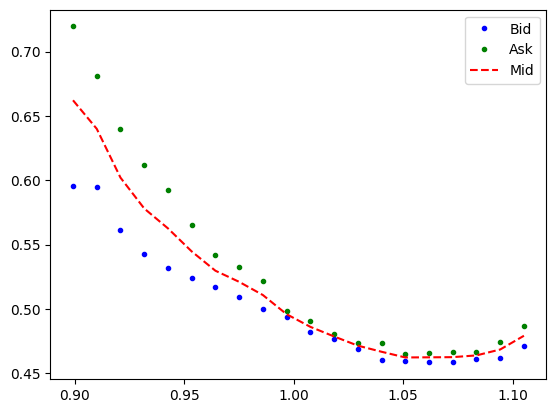

In [6]:
r = 0.00 # TODO: figure out r
ask = np.array(C1['Ask']) / F_T
ask = np.concatenate((np.array([1]), ask))
bid = np.array(C1['Bid']) / F_T
bid = np.concatenate((np.array([1]), bid))
mid = 0.5 * (ask + bid)
k = np.array(C1['Strike']) / F_T
k = np.concatenate((np.array([0]), k))
numK = len(k)
t1 = 6/365

# Plot data
fig, ax = plt.subplots()
ax.plot(np.array(C1['Strike/Spot']), np.array(iv_2_vec(bid[1:],k[1:],t1,0.0,1.)), 'b.', label='Bid')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv_2_vec(ask[1:],k[1:],t1,0.0,1.)), 'g.', label='Ask')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv_2_vec(mid[1:],k[1:],t1,0.0,1.)), 'r--', label='Mid')
plt.legend()
plt.show()

In [7]:
ONE_OVER_2000 = 1 / 2000
def unif_prior(x):
    return ONE_OVER_2000 if 0 <= x <= 2000 else 0.0

In [8]:
def betas(k, lambda_vals):
    return np.cumsum(lambda_vals * k)
def alphas(lambda_vals):
    return np.cumsum(lambda_vals)

In [9]:
delta_k = np.diff(np.array(k))
delta_k = [d for d in delta_k]
delta_k.append(2000 - k[-1])
delta_k = np.array(delta_k)

def gammas(k, lambda_vals, betas, alphas, delta_k):
    gamma_vals = []
    for i in range(k.size):
        if (alphas[i] == 0):
            gamma_vals.append(-betas[i] + np.log(delta_k[i]))
        elif alphas[i] * delta_k[i] >= 709.8:
            if (i + 1) < k.size:
                gamma_vals.append(-betas[i] + alphas[i] * k[i + 1]  - np.log(alphas[i]))
            else:
                gamma_vals.append(-betas[i] + alphas[i] * 2000  - np.log(alphas[i]))
        else:
            h_val = (np.exp(alphas[i] * delta_k[i]) - 1) / alphas[i]
            gamma_vals.append(-betas[i] + alphas[i] * k[i] + np.log(h_val))
    return np.array(gamma_vals)


def log_sum_egamma(k, lambda_vals, betas, alphas, delta_k):
    gamma_vals = gammas(k, lambda_vals, betas, alphas, delta_k)
    max_gamma = np.max(gamma_vals)
    return max_gamma + np.log(np.sum(np.exp(gamma_vals - max_gamma)))

In [10]:
LOG_ONE_OVER_2000 = np.log(ONE_OVER_2000)

def log_expectation_prior(k, lambda_vals, betas, alphas, delta_k):
    gam = log_sum_egamma(k, lambda_vals, betas, alphas, delta_k)
    return LOG_ONE_OVER_2000 + gam

In [11]:
def density(x, lambdaOpt, k, betas, alphas, delta_k):
    expo = np.sum(lambdaOpt * np.maximum(x -k, 0))
    exp  = np.exp(expo)
    expect = np.exp(log_expectation_prior(k, lambdaOpt, betas, alphas, delta_k))
    return np.max(exp / expect * unif_prior(x), 0)

In [12]:
omega = 1E-4 * (ask - bid)
mmask = mid - ask
mmbid = mid - bid

def f_ij(lambda_ij):
    vals = []
    for i in range(lambda_ij.size):
        if omega[i] == 0:
            vals.append(0.0)
        elif lambda_ij[i] > 1 / omega[i] * mmbid[i]:
            val = 0.5 / omega[i] * mmbid[i] * mmbid[i] - lambda_ij[i] * mmbid[i]
            vals.append(val)
        elif lambda_ij[i] < 1 / omega[i] * mmask[i]:
            val = 0.5 / omega[i] * mmask[i] * mmask[i] - lambda_ij[i] * mmask[i]
            vals.append(val)
        else:
            vals.append(-0.5 * omega[i] * lambda_ij[i] * lambda_ij[i])
    return np.array(vals)

def derivs_fij(lambda_ij):
    vals = []
    for i in range(lambda_ij.size):
        if omega[i] == 0:
            vals.append(0.0)
        elif lambda_ij[i] > 1 / omega[i] * mmbid[i]:
            val = - mmbid[i]
            vals.append(val)
        elif lambda_ij[i] < 1 / omega[i] * mmask[i]:
            val = - mmask[i]
            vals.append(val)
        else:
            vals.append(- omega[i] * lambda_ij[i])
    return np.array(vals)


def f_j(lambda_ij, k, delta_k, bid, ask, mid):
    beta = betas(k, lambda_ij)
    alpha = alphas(lambda_ij)
    expec = log_expectation_prior(k, lambda_ij, beta, alpha, delta_k)
    return expec - np.sum(lambda_ij * mid + f_ij(lambda_ij))


In [13]:
def get_deriv_k(i, k, delta_k, bid, ask, mid, lambda_ij, alphas):
    vals = []
    for j in range(i, k.size):
        if alphas[j] == 0:
            val = -k[i] + k[j] + delta_k[j] * 0.5
            vals.append(val)
        elif 709.8 < alphas[j] * delta_k[j]:
            new_k = k[j+1] if j+1 < k.size else 2000
            val = -k[i] + new_k - 1. / alphas[j]
            vals.append(val)
        else:
            denom = np.exp(alphas[j] * delta_k[j]) -1.
            val = -k[i] + k[j] + delta_k[j] * np.exp(alphas[j] * delta_k[j]) / denom - 1. / alphas[j]
            vals.append(val)
    return np.array(vals)






def grad_fj(lambda_ij, k, delta_k, bid, ask, mid):
    beta = betas(k, lambda_ij)
    alpha = alphas(lambda_ij)
    gamma_vals = gammas(k, lambda_ij, beta, alpha, delta_k)
    max_gamma = np.max(gamma_vals)
    s = np.sum(np.exp(gamma_vals - max_gamma))
    vals = []
    for i in range(len(lambda_ij)):
        max_loc = np.max(gamma_vals[i:])
        derivs = get_deriv_k(i, k, delta_k, bid, ask, mid, lambda_ij, alpha)
        val = np.exp(max_loc - max_gamma) * np.sum(np.exp(gamma_vals[i:]- max_loc) * derivs) / s
        vals.append(val)


    grad_sum =  mid + derivs_fij(lambda_ij)
    return np.array(vals) - grad_sum

In [14]:
def getM(K,k):
    if K >= k[-1]:
        return k.size - 1
    m = int(0)
    for i in range(1,k.size):
        if K < k[i]:
            m = int(i - 1)
            return m
    return m

def get_C_omegaK(i, k, delta_k, bid, ask, mid, lambda_ij, alphas, K):
    vals = []
    for j in range(i, k.size):
        if alphas[j] == 0:
            val = -K + k[j] + delta_k[j] * 0.5
            vals.append(val)
        elif 709.8 < alphas[j] * delta_k[j]:
            new_k = k[j+1] if j+1 < k.size else 2000
            val = -K + new_k - 1. / alphas[j]
            vals.append(val)
        else:
            denom = np.exp(alphas[j] * delta_k[j]) -1.
            val = -K + k[j] + delta_k[j] * np.exp(alphas[j] * delta_k[j]) / denom - 1. / alphas[j]
            vals.append(val)
    return np.array(vals)

def gamma_m(m, K, k, delta_k, bid, ask, mid, lambda_ij, alphas, betas):
    delta = 0.0
    if m + 1 < k.size:
        delta = k[m+1] - K
    else:
        delta = 2000 - K

    if (alphas[m] == 0):
        return -betas[m] + np.log(delta)
    elif alphas[m] * delta >= 709.8:
        if (m + 1) < k.size:
            -betas[m] + alphas[m] * k[m+1]  - np.log(alphas[m])
        else:
            return -betas[m] + alphas[m] * 2000  - np.log(alphas[m])
    else:
        h_val = (np.exp(alphas[m] * delta) - 1) / alphas[m]
        rval = -betas[m] + alphas[m] * K + np.log(h_val)
        return rval

def omega_m(m, K, k, delta_k, bid, ask, mid, lambda_ij, alphas):
    delta = 0.0
    if m + 1 < k.size:
        delta = k[m+1] - K
    else:
        delta = 2000 - K
    if alphas[m] == 0.0:
        return delta * 0.5
    elif 709.8 < alphas[m] * delta:
            #val = delta_k[m] - 1. / alphas[m]
            val = - 1. / alphas[m]
            return val
    else: ## do numerical optim ala grad computation here
        denom = np.exp(alphas[m] * delta) - 1.0
        return delta * np.exp(alphas[m] * delta) / denom - 1.0 / alphas[m]

def C_K(K, lambda_ij, k, delta_k, bid, ask, mid):
    beta = betas(k, lambda_ij)
    alpha = alphas(lambda_ij)
    gamma_vals = gammas(k, lambda_ij, beta, alpha, delta_k)
    max_gamma = np.max(gamma_vals)
    s = np.sum(np.exp(gamma_vals - max_gamma))

    m = getM(K, k)

    w_ij_K = get_C_omegaK(m + 1, k, delta_k, bid, ask, mid, lambda_ij, alpha, K)
    gm = gamma_m(m, K, k, delta_k, bid, ask, mid, lambda_ij, alpha, beta)
    wm = omega_m(m, K, k, delta_k, bid, ask, mid, lambda_ij, alpha)

    if m + 1 >= gamma_vals.size:
        return np.exp(-max_gamma) * ( np.exp(gm) * wm) / s
    local_max = np.max(gamma_vals[m + 1:])
    local_max = np.maximum(local_max, gm)

    num =  np.exp(gm - local_max) * wm + np.sum( np.exp(gamma_vals[m+1:] - local_max) * w_ij_K )
    adj = np.exp(local_max - max_gamma)
    return  adj * num / s

    


In [15]:
res = minimize(f_j, x0 = np.zeros(k.size), args = (k, delta_k, bid, ask, mid), jac = grad_fj, method="BFGS",tol = 1E-12, options={"maxfev":10000, "maxfun": 10000, "gtol":1E-6})
res

C:\Users\marti\AppData\Local\Temp\ipykernel_25876\2699570764.py:1: OptimizeWarning: Unknown solver options: maxfev, maxfun
  res = minimize(f_j, x0 = np.zeros(k.size), args = (k, delta_k, bid, ask, mid), jac = grad_fj, method="BFGS",tol = 1E-12, options={"maxfev":10000, "maxfun": 10000, "gtol":1E-6})


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -9.022310128807375
        x: [ 1.413e+01 -1.853e+02 ... -1.071e+02  8.566e+01]
      nit: 356
      jac: [ 9.538e-08 -1.640e-07 ... -3.828e-08 -1.259e-08]
 hess_inv: [[ 2.879e+03 -1.333e+04 ... -2.084e+03  1.363e+03]
            [-1.333e+04  7.153e+05 ... -7.207e+04  5.575e+04]
            ...
            [-2.084e+03 -7.207e+04 ...  2.647e+06 -1.193e+06]
            [ 1.363e+03  5.575e+04 ... -1.193e+06  7.042e+05]]
     nfev: 360
     njev: 360

In [16]:
calls_analytical = [C_K(kk, res.x, k, delta_k, bid, ask, mid) for kk in k]

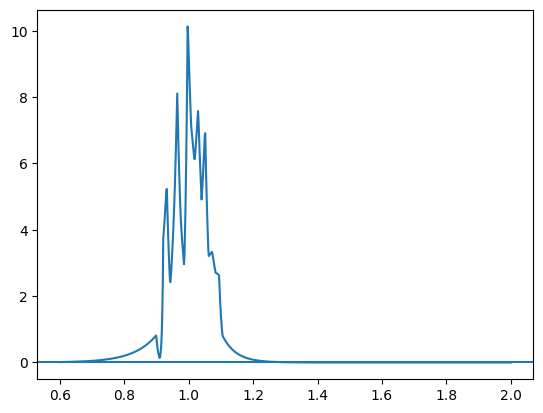

In [17]:
xxz = np.linspace(0.6,2, 1000)
den = []
beta=betas(k,res.x)
alpha=alphas(res.x)
for x in xxz:
    den.append(density(x, res.x, k, beta, alpha, delta_k))

plt.plot(xxz, den)
plt.axhline(0.0)

In [18]:
dd = lambda arg: density(arg, res.x, k, beta, alpha, delta_k)

integrate.quad(dd, 0.001, 4)

C:\Users\marti\AppData\Local\Temp\ipykernel_25876\1232968590.py:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrate.quad(dd, 0.001, 4)


(1.000036126142818, 0.00043128321735341757)

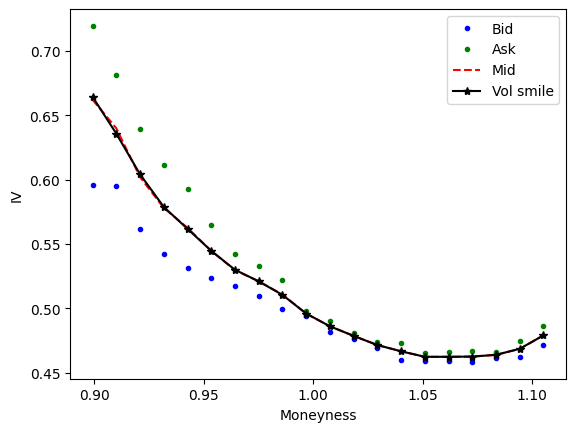

In [25]:
# Plot data
fig, ax = plt.subplots()
T_ = 6/365
ax.plot(np.array(C1['Strike/Spot']), np.array(iv_2_vec(bid[1:],k[1:],T_,0,1.)), 'b.', label='Bid')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv_2_vec(ask[1:],k[1:],T_,0,1.)), 'g.', label='Ask')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv_2_vec(mid[1:],k[1:],T_,0,1.)), 'r--', label='Mid')
v = iv_2_vec(np.array(calls_analytical[1:]), k[1:], T_, 0, 1.)
ax.plot(np.array(C1['Strike/Spot']), v, 'k', label='Vol smile', marker="*")
ax.set_ylabel('IV')
ax.set_xlabel('Moneyness')
plt.legend()
plt.show()

In [20]:
v

array([0.55210376, 0.5283341 , 0.50205837, 0.48098198, 0.46681055,
       0.4526107 , 0.4403795 , 0.43291958, 0.4241536 , 0.41210773,
       0.40387786, 0.39766824, 0.39177244, 0.38771135, 0.38417153,
       0.38414582, 0.38431538, 0.3854268 , 0.38935272, 0.39800544])

Slice not free of butterfly arbitrage. Again weird behavior around 2nd strike , might be that this is due to quotes not being 
arb free, retry with other data

In [21]:
kB = np.linspace(0.5, 2, 150)
csB = [C_K(kk, res.x, k, delta_k, bid, ask, mid) for kk in kB]


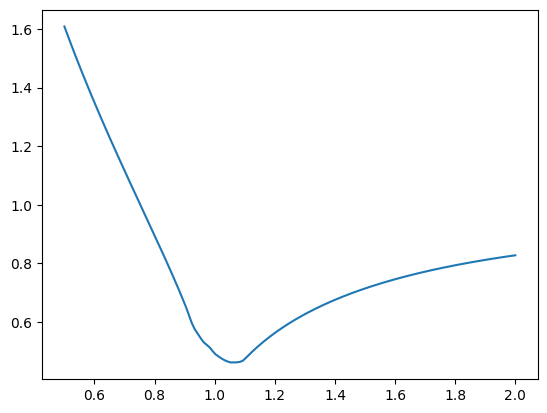

In [26]:
vv = iv_2_vec(csB,kB, T_, 0, 1.)
plt.plot(kB, vv)